In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final_project").getOrCreate()

In [2]:
spark

# load and explore data

In [3]:
df2004 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2004.csv",
                      header = True, inferSchema= True)
df2005 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2005.csv",
                      header = True, inferSchema= True)
df2006 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2006.csv",
                      header = True, inferSchema= True)
df2007 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2007.csv",
                      header = True, inferSchema= True)
df2008 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2008.csv",
                      header = True, inferSchema= True)
df2009 = spark.read.csv("s3://jenova73/final/311_Service_Requests_for_2009.csv",
                      header = True, inferSchema= True)
df2010 = spark.read.csv("s3://jenova73/final/311_Service_Requests_from_2010_to_Present (1).csv",
                      header = True, inferSchema= True)

In [4]:
df2010 = spark.read.csv("s3://jenova73/final/311_Service_Requests_from_2010_to_Present (1).csv",
                      header = True, inferSchema= True)
df2010.printSchema()
df2004.printSchema()


root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

In [5]:
columns = ['Created Date','Closed Date','Agency','Agency Name',
          'Complaint Type','Descriptor','Location Type','Incident Zip',
          'City','Status','Community Board','Borough','Park Borough',
          'Latitude','Longitude']
df2011=df2010.select(*columns)

In [6]:
merged = df2004.union(df2005)
merged = merged.union(df2006)
merged = merged.union(df2007)
merged = merged.union(df2008)
merged = merged.union(df2009)
merged = merged.select(*columns)
merged = merged.union(df2011)


In [7]:
data = merged
                    

In [8]:
data.printSchema()

root
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [9]:
data.count()

32953164

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StringType, IntegerType, FloatType

In [11]:
data=data.dropna()

In [12]:
data.count()

21920178

### Data Cleaning

In [13]:
from pyspark.sql.functions import to_date, to_timestamp, datediff,year, month
df1=data.withColumn("start_date", to_date('Created Date','MM/dd/yyyy HH:mm:ss'))
df1=df1.withColumn("end_date", to_date('Closed Date','MM/dd/yyyy HH:mm:ss'))
df1=df1.withColumn('Time',datediff('end_date','start_date'))
df1= df1.withColumn('Timebin',F.when(df1.Time<3, 0).otherwise(F.when(df1.Time<6,1).otherwise(2)))
df1=df1.withColumn('Year',year('start_date'))
df1=df1.withColumn('Month',month('start_date'))
df1=df1.drop('Created Date','Closed Date','start_date','end_date','Time')


In [14]:
df1 = df1.withColumn("Timebin",col("Timebin").cast(StringType()))
df1 = df1.withColumn("Year",col("Year").cast(StringType()))
df1 = df1.withColumn("Month",col("Month").cast(StringType()))


In [15]:
df1.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



# prepare data

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import col

In [17]:
(train, test) = (df1.randomSplit([0.75,0.25]))

### change string or integer into index

In [18]:
df1.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



In [19]:
df1=df1.drop('Longitude','Latitude')
df1=df1.dropna()

In [23]:
Agency_indexer = StringIndexer(inputCol = 'Agency',outputCol='Agency_index').setHandleInvalid("keep")
Agency_Name_indexer = StringIndexer(inputCol = 'Agency Name',outputCol='Agency_Name_index').setHandleInvalid("keep")
Complaint_Type_indexer = StringIndexer(inputCol = 'Complaint Type',outputCol='Complaint_Type_index').setHandleInvalid("keep")
Descriptor_indexer = StringIndexer(inputCol = 'Descriptor',outputCol='Descriptor_index').setHandleInvalid("keep")
Location_Type_indexer = StringIndexer(inputCol = 'Location Type',outputCol='Location_Type_index').setHandleInvalid("keep")
Incident_indexer = StringIndexer(inputCol = 'Incident Zip',outputCol='Incident_index').setHandleInvalid("keep")
City_indexer = StringIndexer(inputCol = 'City',outputCol='City_index').setHandleInvalid("keep")
Status_indexer = StringIndexer(inputCol = 'Status',outputCol='Status_index').setHandleInvalid("keep")
Community_Board_indexer = StringIndexer(inputCol = 'Community Board',outputCol='Community_Board_index')
Borough_indexer = StringIndexer(inputCol = 'Borough',outputCol='Borough_index').setHandleInvalid("keep")
Park_indexer= StringIndexer(inputCol = 'Park Borough',outputCol='Park_index').setHandleInvalid("keep")
Timebin_indexer = StringIndexer(inputCol = 'Timebin',outputCol='label').setHandleInvalid("keep")
Year_indexer = StringIndexer(inputCol = 'Year',outputCol='Year_index').setHandleInvalid("keep")
Month_indexer = StringIndexer(inputCol = 'Month',outputCol='Month_index').setHandleInvalid("keep")

In [24]:
assembler = VectorAssembler(inputCols = ["Agency_index", 
                                         "Agency_Name_index",
                                         "Complaint_Type_index",
                                         "Descriptor_index",
                                         "Location_Type_index",
                                         "Incident_index",
                                         "Status_index",
                                         "Borough_index",
                                         "Community_Board_index",
                                         "Park_index",'City_index',
                                        'Year_index','Month_index'],
                            outputCol = 'features')

### Logistics Regression

In [25]:
Logistic_regression_pipeline = Pipeline(stages=[Agency_indexer,
                                       Agency_Name_indexer,Complaint_Type_indexer,
                                     Descriptor_indexer,Location_Type_indexer,Incident_indexer,
                                     Status_indexer,Community_Board_indexer,Borough_indexer,
                                     Park_indexer,City_indexer,Timebin_indexer,Year_indexer,Month_indexer,
                                     assembler,
                                     LogisticRegression(featuresCol = 'features',labelCol = 'label')])

In [26]:
sample_train= train.limit(300).cache()

In [27]:
sample_train.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Community Board: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Park Borough: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Timebin: string (nullable = false)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



In [28]:
model_alpha = Logistic_regression_pipeline.fit(sample_train)

In [29]:
logistic_model = Logistic_regression_pipeline.fit(train)

In [30]:
prediction = logistic_model.transform(test)

In [31]:
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.5426744460096451
Precision  0.5191945561119488
Recall  0.5961575867498965
Accuracy  0.5961575867498965


### Random Forest 

In [39]:
rf = RandomForestClassifier(featuresCol = 'features',labelCol = 'label',maxDepth=2,maxBins=2000)
paramGrid = ParamGridBuilder().addGrid(rf.maxBins, 
                                       [2000]).addGrid(rf.maxDepth, [8]).addGrid(rf.impurity, ["entropy", "gini"]).build()


In [40]:
rf_pipeline = Pipeline(stages=[Agency_indexer,
                                Agency_Name_indexer,Complaint_Type_indexer,
                                Descriptor_indexer,Location_Type_indexer,Incident_indexer,
                                     Status_indexer,Community_Board_indexer,Borough_indexer,
                                     Park_indexer,City_indexer,Timebin_indexer,Year_indexer,Month_indexer,
                                     assembler,rf])

In [47]:
rf_model = rf_pipeline.fit(train).cache()

In [48]:
rf_prediction = rf_model.transform(test).cache()

In [49]:
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(rf_prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(rf_prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(rf_prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(rf_prediction, 
                                      {evaluator.metricName: 'accuracy'}))

F1-Score  0.6594932084462521
Precision  0.6476434647412193
Recall  0.7109590340868658
Accuracy  0.7109590340868658


In [50]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
ytrue = prediction.select('label')
ytrue = ytrue.toPandas()

ypred = prediction.select('prediction')
ypred = ypred.toPandas()


In [53]:
ypred.describe()

,prediction
count,5.480410e+06
mean,3.646220e-01
std,4.814753e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,2.000000e+00


In [54]:
cnf_matrix = confusion_matrix(ytrue, ypred,labels=range(3))

In [55]:
cnf_matrix

array([[2134383,  515587,     117],
       [ 852414, 1132760,     237],
       [ 495734,  349133,      45]])

Normalized confusion matrix
[[8.05401106e-01 1.94554745e-01 4.41494940e-05]
 [4.29338812e-01 5.70541817e-01 1.19370750e-04]
 [5.86728559e-01 4.13218181e-01 5.32599845e-05]]


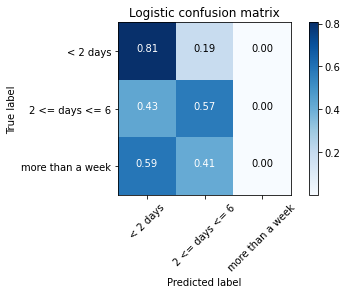

In [56]:
class_names = ['< 2 days','2 <= days <= 6','more than a week',]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Logistic confusion matrix')
plt.show()

In [57]:
ytrue = rf_prediction.select('label')
ytrue = ytrue.toPandas()

ypred = rf_prediction.select('prediction')
ypred = ypred.toPandas()



In [58]:
cnf_matrix = confusion_matrix(ytrue, ypred,)
cnf_matrix

array([[2002707,  647380,       0],
       [  91771, 1893640,       0],
       [ 117921,  726991,       0]])

Normalized confusion matrix
[[0.75571368 0.24428632 0.        ]
 [0.04622267 0.95377733 0.        ]
 [0.13956601 0.86043399 0.        ]]


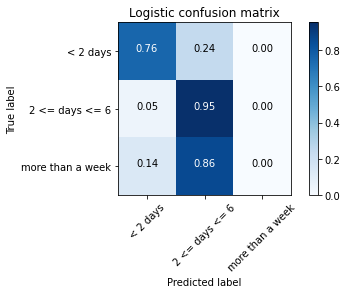

In [59]:
class_names = ['< 2 days','2 <= days <= 6','more than a week',]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Random Forest confusion matrix')
plt.show()